In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

## Create necessary classes and functions

Create class to handle "cities"

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    #child = childP1 + childP2
    child = childP2[:startGene] + childP1 + childP2[startGene:]
    return child

Create function to run crossover over full mating pool

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [11]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [12]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Plot the progress

In [15]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    ###
    showMap(pop[-1])

Run the function with our assumptions to see how distance has improved in each generation

## showMap

In [16]:
def showMap(cityList):
    print(cityList)
    prev=City(0,0)
    for i in cityList:
        plt.plot(i.x, i.y,'ro')
        plt.plot(prev.x,prev.y, 'k-')
        if(prev.x == 0 and prev.y == 0):
            prev=i 
            continue;
        else:
            plt.plot([prev.x,i.x],[prev.y, i.y],'k-')
            #print('prev x:', prev.x, ' prev y:', prev.y,' i x:', i.x, ' i y:', i.y)
            prev=i
    plt.show()

## All-in-one

In [17]:
def runGA(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []  
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
          
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    showMap(pop[-1])
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    return bestRoute

## Create list of cities

Artifical samples

In [18]:
cityList = []
for i in range(0,30):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Real-life samples

In [25]:
cityList = []
with open('att48_xy.txt') as f:
    for line in f:
        cityList.append(City(x=int(line.split()[0]), y=int(line.split()[1])))

In [20]:
#Reduce the size by x0.1
cityList = []
with open('att48_xy.txt') as f:
    for line in f:
        cityList.append(City(x=int(int(line.split()[0])/10), y=int(int(line.split()[1])/10)))

In [21]:
print(cityList)

[(673,145), (223,1), (553,142), (40,84), (308,164), (760,445), (757,371), (726,126), (689,188), (111,204), (546,260), (598,287), (470,267), (461,203), (634,268), (610,66), (761,518), (746,359), (773,472), (590,356), (448,336), (610,111), (519,218), (163,280), (430,232), (67,100), (755,481), (754,398), (317,75), (735,450), (754,280), (324,330), (642,317), (460,119), (2,221), (724,377), (776,459), (739,224), (348,282), (627,213), (498,14), (191,156), (728,489), (750,323), (1,267), (680,299), (518,325), (302,194)]


## Find indices

In [22]:
cityListRaw = []
with open('att48_xy.txt') as f:
    for line in f:
        cityListRaw.append((int(line.split()[0]), int(line.split()[1])))

In [23]:
def findIndex(cityResult):
    cityResultIndex=[]
    for ix in cityResult:
        cityResultIndex.append(cityList.index(ix))
    print(cityResultIndex)

## Running the genetic algorithm

Initial distance: 127797.56183560289


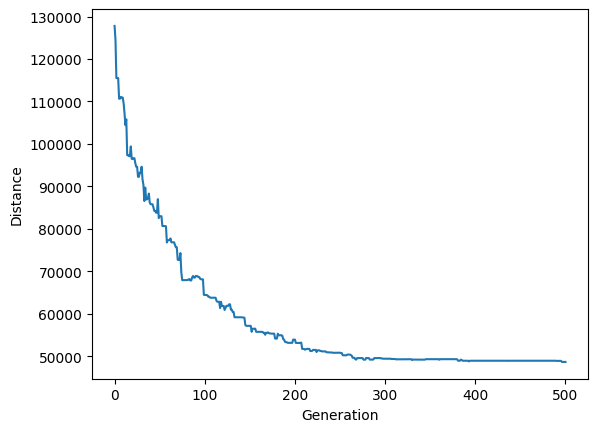

[(401,841), (675,1006), (2233,10), (6107,669), (6101,1110), (6734,1453), (7265,1268), (7392,2244), (7545,2801), (7762,4595), (7732,4723), (7352,4506), (7248,3779), (6426,3173), (5989,2873), (5900,3561), (5185,3258), (4706,2674), (4307,2322), (3023,1942), (3082,1644), (1633,2809), (1916,1569), (3177,756), (4608,1198), (4612,2035), (3484,2829), (3245,3305), (4483,3369), (5199,2182), (5468,2606), (6271,2135), (6347,2683), (6807,2993), (7462,3590), (7573,3716), (7541,3981), (7608,4458), (7555,4819), (7611,5184), (7280,4899), (7509,3239), (6898,1885), (5530,1424), (4985,140), (1112,2049), (10,2676), (23,2216)]


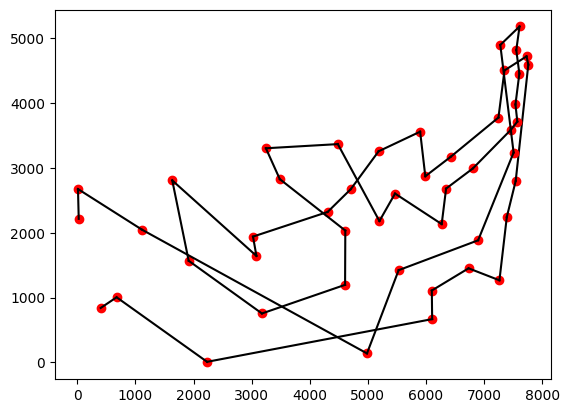

Final distance: 48657.705381599844
[3, 25, 1, 2, 21, 0, 7, 37, 30, 36, 18, 29, 35, 32, 11, 19, 46, 12, 24, 47, 4, 23, 41, 28, 33, 13, 38, 31, 20, 22, 10, 39, 14, 45, 17, 6, 27, 5, 26, 16, 42, 43, 8, 15, 40, 9, 44, 34]


In [26]:
cityResult=runGA(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
findIndex(cityResult)

### References

https://optimization.mccormick.northwestern.edu/index.php/Traveling_salesman_problems
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/
https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html